<a href="https://colab.research.google.com/github/AbhilashDatta/Facial_Expression_Recognizer/blob/main/FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AbhilashDatta/Facial_Expression_Recognizer.git
%cd Facial_Expression_Recognizer

Cloning into 'Facial_Expression_Recognizer'...
remote: Enumerating objects: 34062, done.
remote: Counting objects: 100% (34062/34062), done.
remote: Compressing objects: 100% (34056/34056), done.
remote: Total 34062 (delta 6), reused 34060 (delta 5), pack-reused 0
Receiving objects: 100% (34062/34062), 52.48 MiB | 49.62 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/Facial_Expression_Recognizer


In [2]:
!pip install livelossplot

In [3]:
# Importing Libraries

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import tensorflow as tf
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.4.1


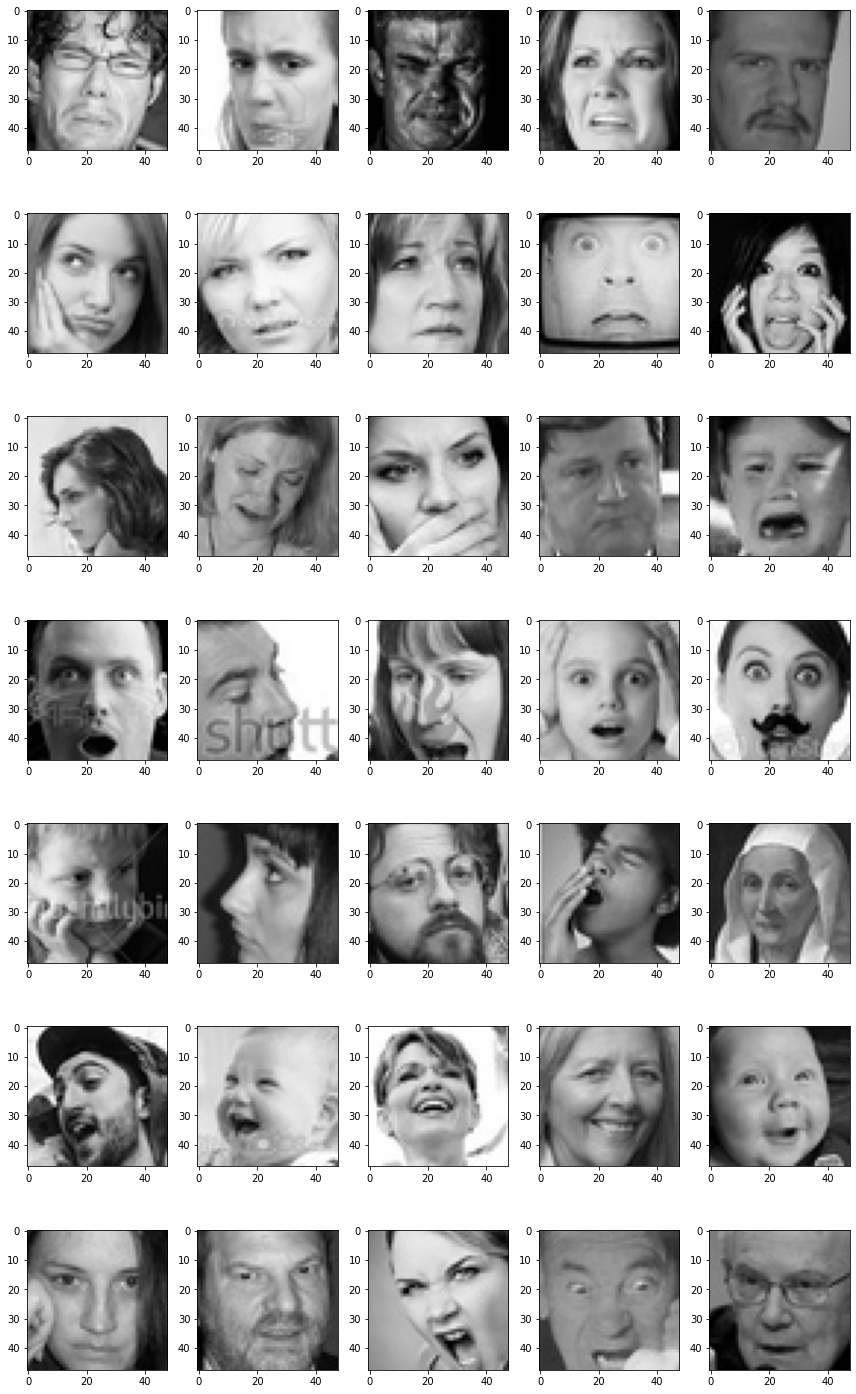

In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
images = []

def plot_example_images(plt):
  img_size = 48
  plt.figure(0, figsize=(12,20))
  ctr = 0

  for expression in os.listdir("train/"):
    for i in range(1,6):
      ctr += 1
      plt.subplot(7,5,ctr)
      img = load_img("train/" + expression + "/" +os.listdir("train/" + expression)[i], target_size=(img_size, img_size))
      images.append(img)
      plt.imshow(img, cmap="gray")

  plt.tight_layout()
  return plt

plot_example_images(plt).show()

In [5]:
for expression in os.listdir("train/"):
  print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

436 disgust images
4097 fear images
4830 sad images
3171 surprise images
4965 neutral images
7214 happy images
3995 angry images


In [6]:
for expression in os.listdir("test/"):
  print(str(len(os.listdir("test/" + expression))) + " " + expression + " images")

111 disgust images
1024 fear images
1247 sad images
831 surprise images
1233 neutral images
1774 happy images
958 angry images


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64

data_generator = ImageDataGenerator(horizontal_flip=True)

train_data = data_generator.flow_from_directory("train/",target_size = (img_size,img_size),color_mode='grayscale',batch_size=64,shuffle=True)

test_data = data_generator.flow_from_directory("test/",target_size = (img_size,img_size),color_mode='grayscale',batch_size=64,shuffle=False)


Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
#Initializing the CNN
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.optimizers import Adam

model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

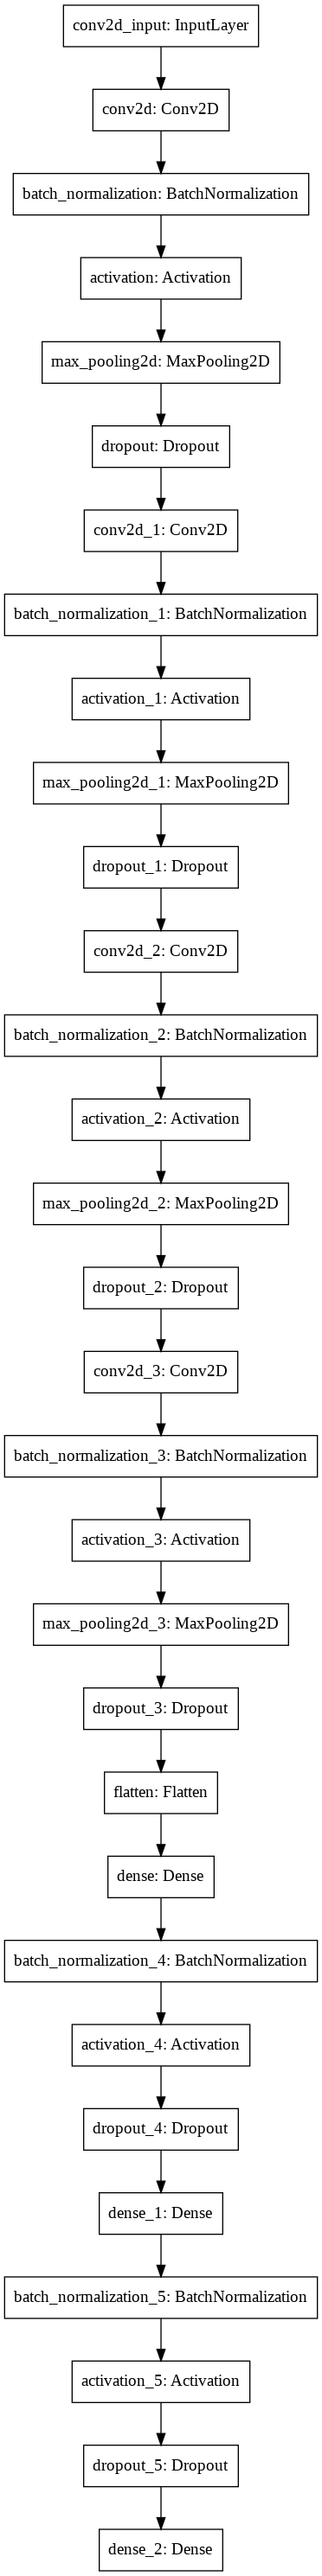

In [14]:
plot_model(model)

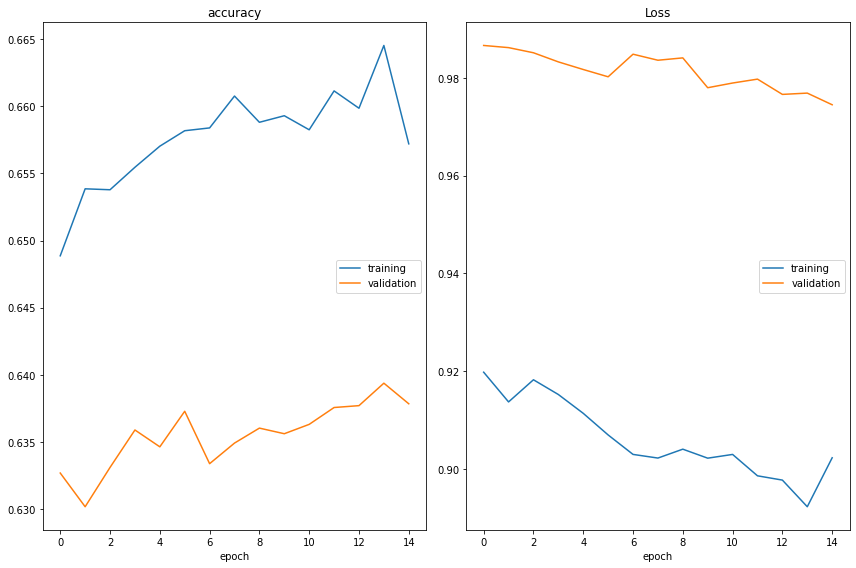

accuracy
	training         	 (min:    0.649, max:    0.665, cur:    0.657)
	validation       	 (min:    0.630, max:    0.639, cur:    0.638)
Loss
	training         	 (min:    0.892, max:    0.920, cur:    0.902)
	validation       	 (min:    0.974, max:    0.987, cur:    0.974)

Epoch 00015: saving model to model_weights.h5


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

epochs = 15
steps_per_epoch = train_data.n//train_data.batch_size
validation_steps = test_data.n//test_data.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = test_data,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [12]:
#converting weights to json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [1]:
from tensorflow.keras.models import model_from_json
from tensorflow.python.keras.backend import set_session
import numpy as np

import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.15
session = tf.compat.v1.Session(config=config)
set_session(session)


class FacialExpressionModel(object):

    EMOTIONS_LIST = ["Angry", "Disgust",
                     "Fear", "Happy",
                     "Neutral", "Sad",
                     "Surprise"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        #self.loaded_model.compile()
        #self.loaded_model._make_predict_function()

    def predict_emotion(self, img):
        global session
        set_session(session)
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]
